In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy import units as u

In [3]:
import pylab as pl
pl.rcParams['figure.figsize'] = (20,8)

In [4]:
import sys
sys.path.append('/lustre/naasc/users/aginsbur/repos/reduction/reduction/')
import imp, diagnostic_images
imp.reload(diagnostic_images)
from diagnostic_images import load_images, show
from spectral_cube import SpectralCube

In [5]:
import os
os.chdir("/lustre/naasc/projects/ALMA_IMF/2017.1.01355.L/imaging_results")

In [6]:
ls -lhrtd W51-E_B6_clean_mask.mask

drwxr-xr-x 3 aginsbur observer 33K Mar 12 10:17 W51-E_B6_clean_mask.mask/


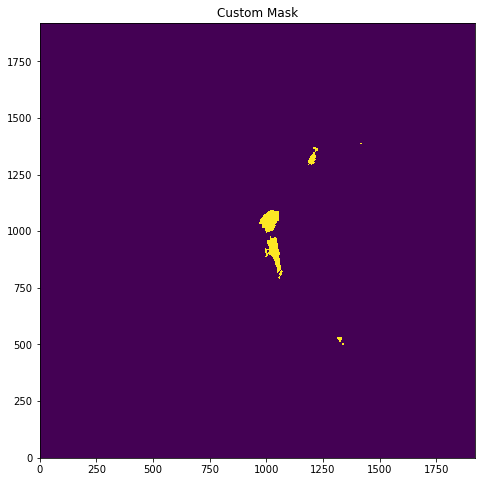

In [7]:
mask = SpectralCube.read('W51-E_B6_clean_mask.mask', format='casa_image')[0]
pl.imshow(mask.value, origin='lower', interpolation='none')
pl.title("Custom Mask")

In [8]:
imgs_dirty_b6, cubes_dirty_b6 = load_images('W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_robust0_dirty')
imgs_before_b6, cubes_before_b6 = load_images('W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_robust0')
imgs_after_b6, cubes_after_b6 = load_images('W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_robust0_selfcal1')
imgs_after2_b6, cubes_after2_b6 = load_images('W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_robust0_selfcal2')

In the images below, the white contours show the mask.

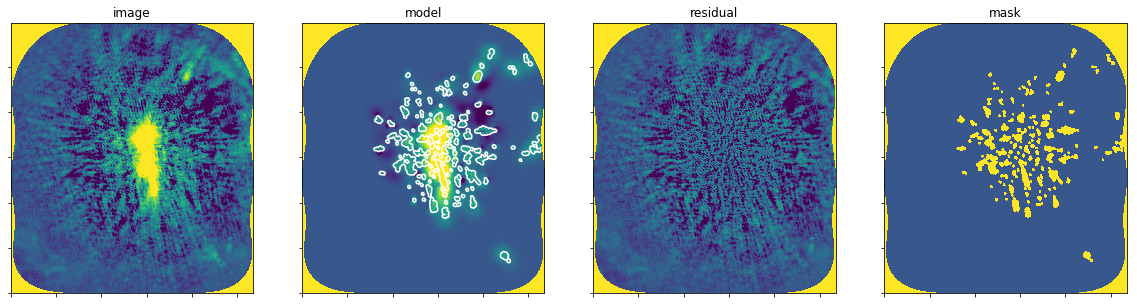

In [9]:
show(imgs_before_b6, vmin=-0.001, vmax=0.01)

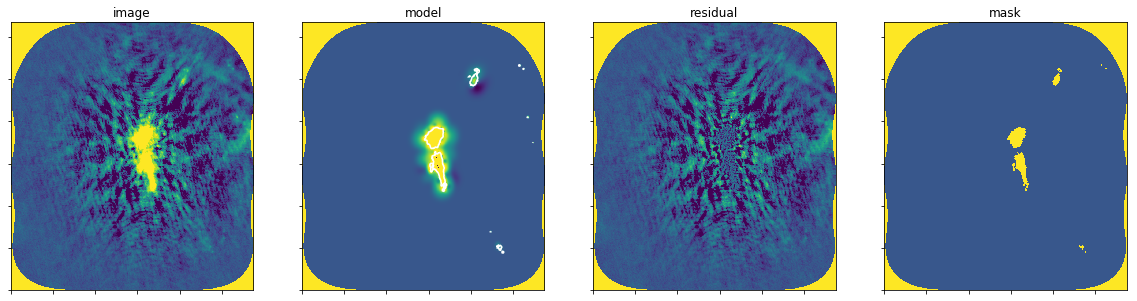

In [10]:
show(imgs_after_b6, vmin=-0.001, vmax=0.01)

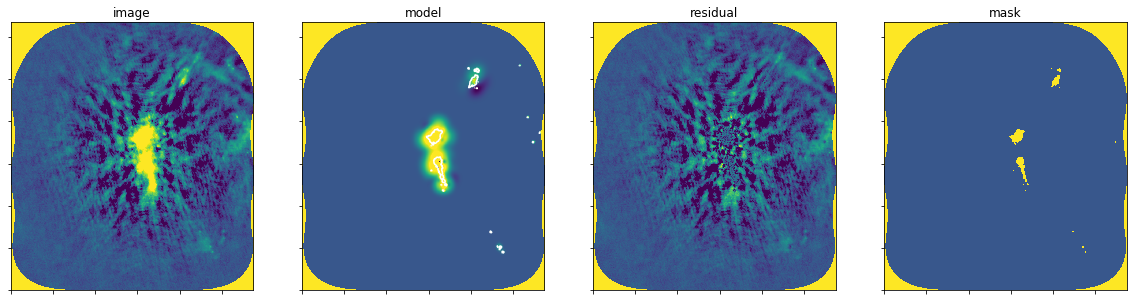

In [11]:
show(imgs_after2_b6, vmin=-0.001, vmax=0.01)

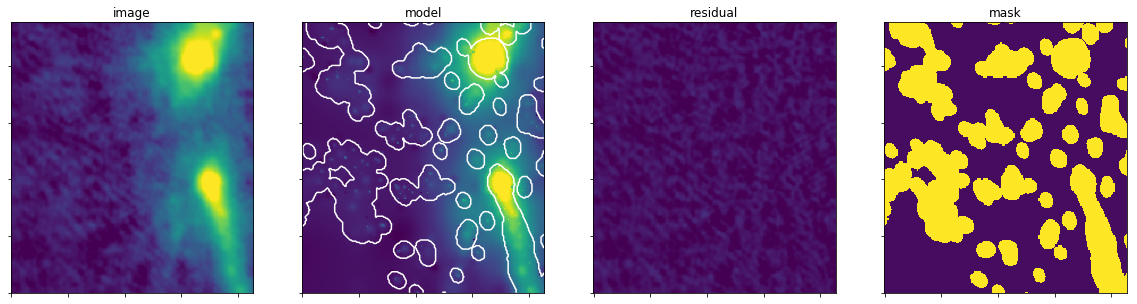

In [12]:
show(imgs_before_b6, vmin=-0.001, vmax=0.1, zoom=0.2)

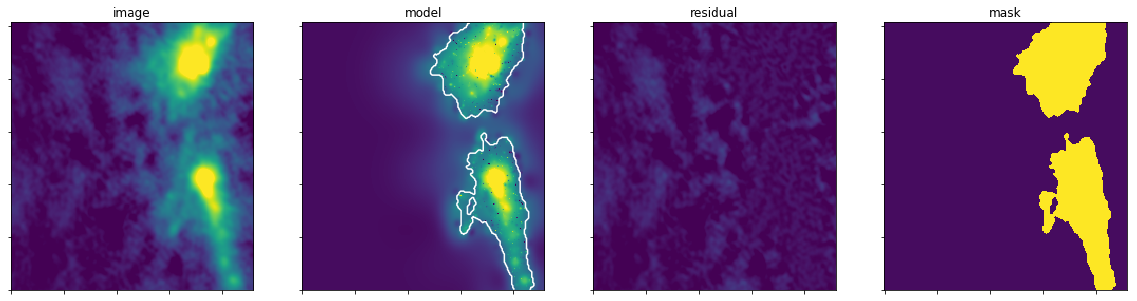

In [13]:
show(imgs_after_b6, vmin=-0.001, vmax=0.1, zoom=0.2)

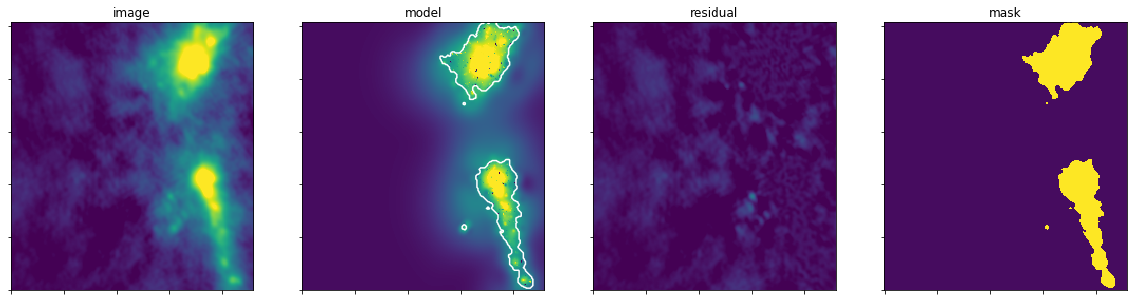

In [14]:
show(imgs_after2_b6, vmin=-0.001, vmax=0.1, zoom=0.2)

Calculate peak to RMS:

In [18]:
for imgs in (imgs_before_b6, imgs_after_b6, imgs_after2_b6):
    rms = np.nanstd(imgs['residual'].value*u.Jy/u.beam) # residual has bad header units
    peak = np.nanmax(imgs['image'].quantity)
    print(f"peak/rms = {peak/rms:0.1f}, peak={peak:0.3f}, rms={rms:0.5f}")

peak/rms = 449.4, peak=0.275 Jy / beam, rms=0.00061 Jy / beam
peak/rms = 568.9, peak=0.405 Jy / beam, rms=0.00071 Jy / beam
peak/rms = 640.0, peak=0.442 Jy / beam, rms=0.00069 Jy / beam


Peak/RMS is rising, though so is the RMS.

Examine the phases: this uses `casatools` (which is only available as a beta library from an NRAO site) to load the table and plot some simple phase information.

In [16]:
import casatools
tb = casatools.table()

# this creates a "context manager" for the table tool that automatically handles tb.open/tb.close operations
class CasaTable(object):
    def __init__(self, file_name):
        self.tb = tb
        self.file_obj = tb.open(file_name)
    def __enter__(self):
        return self.tb
    def __exit__(self, type, value, traceback):
        self.tb.close()

In [19]:
with CasaTable('../W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_phase1_int.cal') as tb:
    print(tb.colnames())
    data = tb.getcol('CPARAM')
    time = tb.getcol('TIME')
    antenna1 = tb.getcol('ANTENNA1')
    antenna2 = tb.getcol('ANTENNA2')
    obsid = tb.getcol('OBSERVATION_ID')
    spwid = tb.getcol('SPECTRAL_WINDOW_ID')
    fieldid = tb.getcol('FIELD_ID')

['TIME', 'FIELD_ID', 'SPECTRAL_WINDOW_ID', 'ANTENNA1', 'ANTENNA2', 'INTERVAL', 'SCAN_NUMBER', 'OBSERVATION_ID', 'CPARAM', 'PARAMERR', 'FLAG', 'SNR', 'WEIGHT']


In [20]:
# data are complex numbers; we're interested in the phase angle
angle = np.angle(data) * 180/np.pi

Plot the phase angle correction from the calibration table vs. entry number.  This allows us to see the typical phase correction split by observation ID rather than by time, since it's very hard to see anything in the angle vs. time plot when multiple independent observations are involved.

In [21]:
uobsids = np.unique(obsid)
nobsids = len(uobsids)
print(nobsids)

13


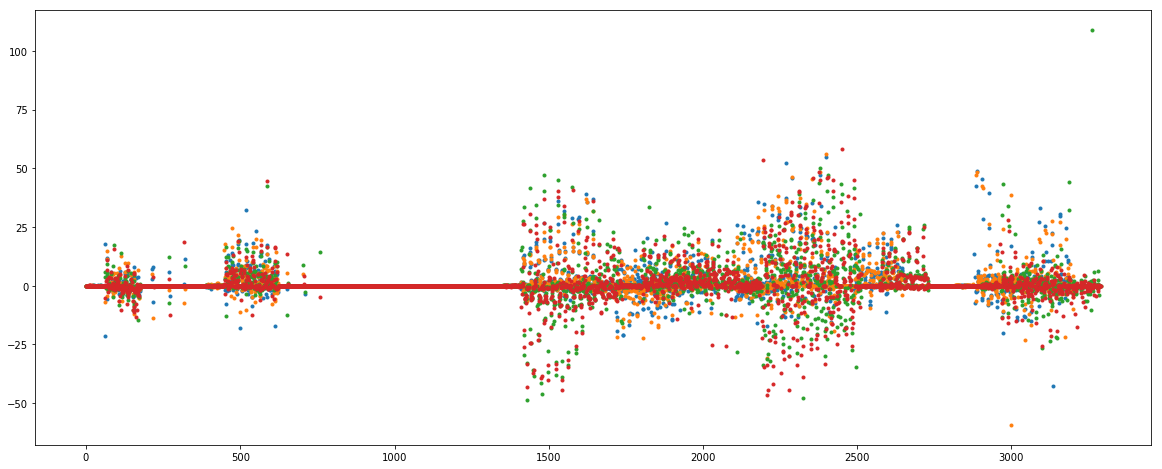

In [22]:
pl.plot(angle[:,0,(antenna1 == 0) & (spwid%13==0)].T, marker='.', linestyle='none')
pl.plot(angle[:,0,(antenna1 == 0) & (spwid%13==1)].T, marker='.', linestyle='none')

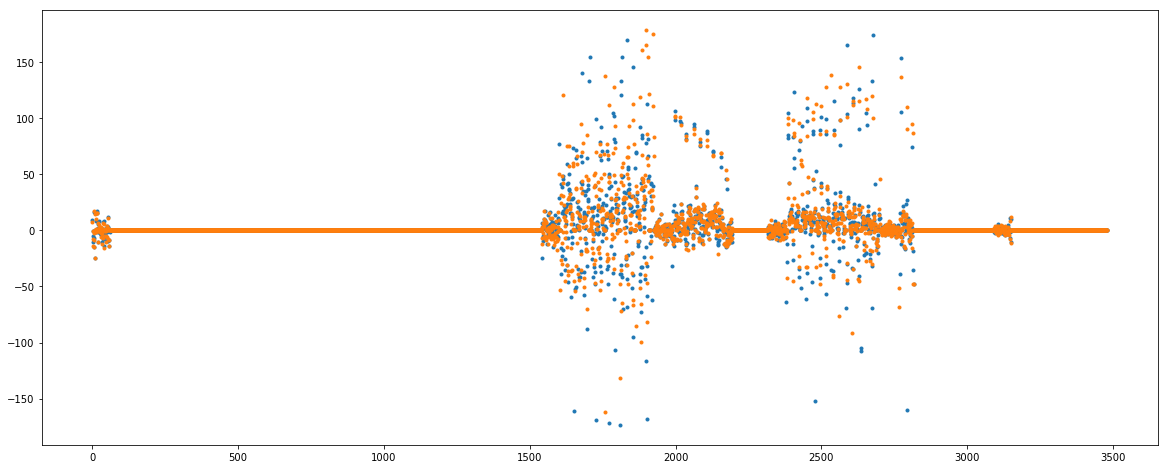

In [23]:
pl.plot(angle[:,0,(antenna1 == 2) & (spwid%13==3)].T, marker='.', linestyle='none')

In [24]:
uantid = np.unique(antenna1)
nants = len(uantid)
print(nants)

83


In [25]:
anglecube = angle.reshape([2,1,antenna1.size//nants,nants])

This creates a "waterfall plot" of scan number on the y-axis vs antenna number on the x-axis.  You can then see the breakdown by what looks like 7m (lots of scans, few antennae), TM1 (medium # of scans) and TM2 (few scans)

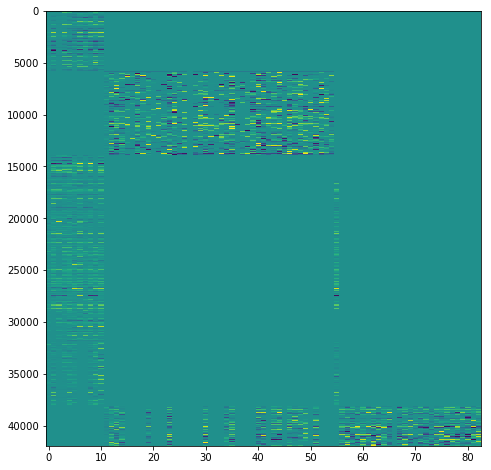

In [26]:
pl.imshow(anglecube[0,0,:,:], aspect=anglecube.shape[3]/anglecube.shape[2])

Because this is a live CASA notebook, we can do a gaincal with amplitude just to see what's going on.

However, I don't recommend this because gaincal takes too long.

In [27]:
from casatasks import gaincal

This took about 2 hours, which is not very good.

In [28]:
if not os.path.exists('test_amplitude_gains_B6_W51E.cal'):
    ms = '../W51-E_B6_uid___A001_X1296_X215_continuum_merged_selfcal.ms'
    gaincal(vis=ms, caltable='test_amplitude_gains_B6_W51E.cal',
            solint='inf', gaintype='G', calmode='a')

In [29]:
with CasaTable('test_amplitude_gains_B6_W51E.cal') as tb:
    print(tb.colnames())
    data = tb.getcol('CPARAM')
    time = tb.getcol('TIME')
    antenna1 = tb.getcol('ANTENNA1')
    antenna2 = tb.getcol('ANTENNA2')
    obsid = tb.getcol('OBSERVATION_ID')
    spwid = tb.getcol('SPECTRAL_WINDOW_ID')
    fieldid = tb.getcol('FIELD_ID')

['TIME', 'FIELD_ID', 'SPECTRAL_WINDOW_ID', 'ANTENNA1', 'ANTENNA2', 'INTERVAL', 'SCAN_NUMBER', 'OBSERVATION_ID', 'CPARAM', 'PARAMERR', 'FLAG', 'SNR', 'WEIGHT']


In [30]:
amp = np.abs(data)

Check the time series of amplitude data.  I believe the time is dominated by the 7m data, which were not imaged here and therefore should not have any amplitude corrections applied.

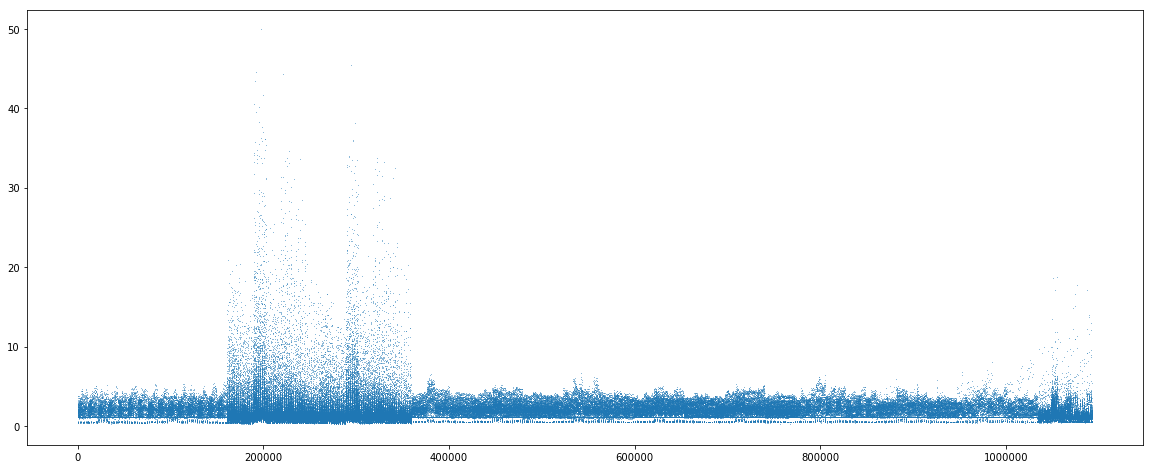

In [31]:
pl.plot(amp[0,0,:], marker=',', linestyle='none', alpha=0.5)

Histograms of the amplitude correction factors.  I have a hard time reconciling this plot with the above one, but the red and green below are almost certainly the 12m data sets, which cluster around 1.  Note that I exclude ``amplitude == 1`` because those are presumably no-solution points.

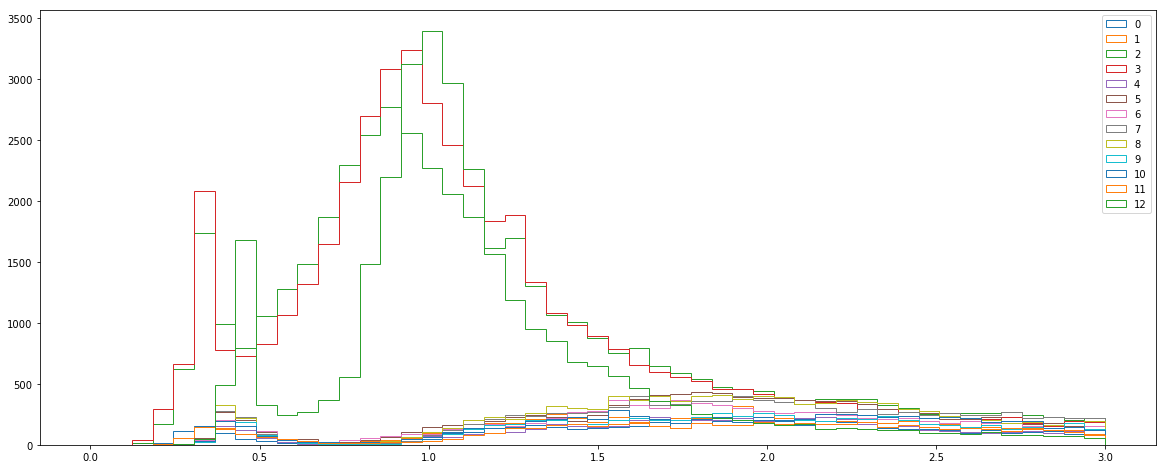

In [32]:
for oid in np.unique(obsid):
    dd = amp[0,0,obsid==oid]
    pl.hist(dd[dd!=1], bins=np.linspace(0,3), histtype='step', label=str(oid))
pl.legend(loc='best')

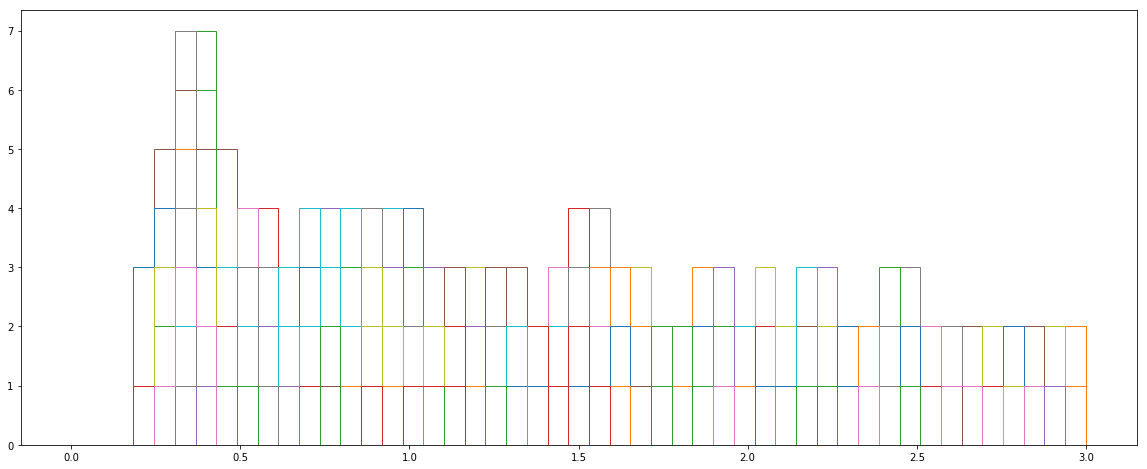

In [33]:
pl.clf()
for aid in np.unique(antenna1):
    for ii,fid in enumerate(np.unique(fieldid[obsid==2])):
        msk = (antenna1==aid) & (obsid==2) & (spwid == 16) & (fieldid==fid)
        if np.any(msk):
            dd = amp[0,0,msk]
            pl.hist(dd[dd!=1], bins=np.linspace(0,3), histtype='step', label=f"{aid}_{fid}")
#pl.legend(loc='best')

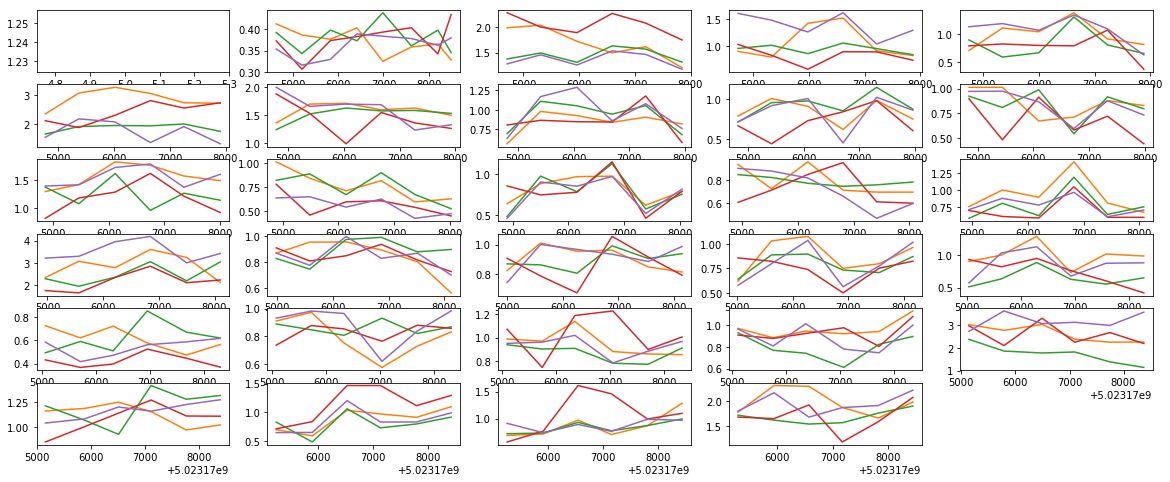

In [34]:
pl.clf()
for aid in np.unique(antenna1)[:15]:
    for ii,fid in enumerate(np.unique(fieldid[obsid==2])):
        ax = pl.subplot(6,5,ii+1)
        msk = (antenna1==aid) & (obsid==2) & (spwid == 16) & (fieldid==fid)
        if np.any(msk):
            dd = amp[0,0,msk]
            tm = time[msk]
            m2 = dd!=1
            srt = np.argsort(tm)
            ax.plot(tm[srt[m2]], dd[srt[m2]])
#pl.legend(loc='best')

In [35]:
np.unique(spwid[obsid==2])
len(np.unique(fieldid[obsid==2]))

29

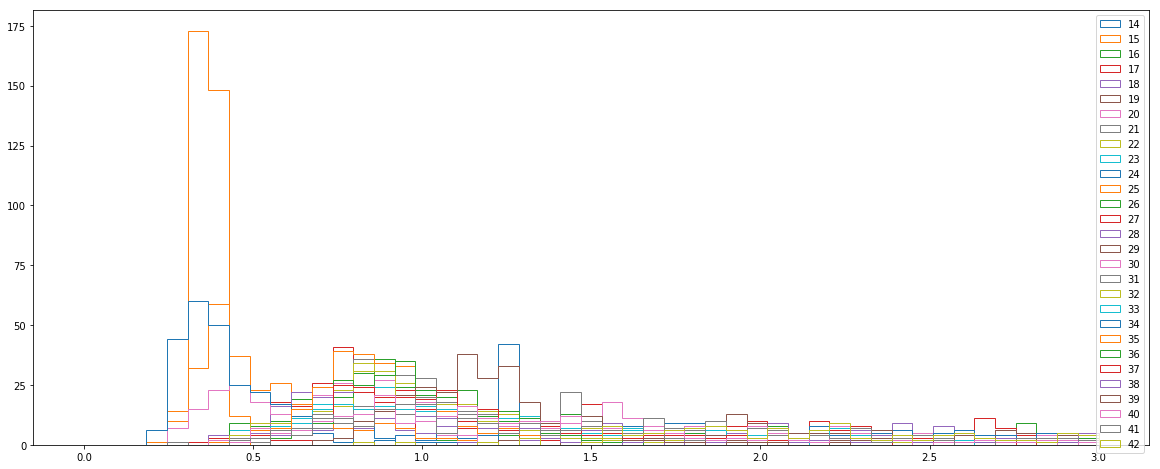

In [36]:
pl.clf()
for ii,fid in enumerate(np.unique(fieldid[obsid==2])):
    msk = (obsid==2) & (spwid == 16) & (fieldid==fid)
    if np.any(msk):
        dd = amp[0,0,msk]
        pl.hist(dd[dd!=1], bins=np.linspace(0,3), histtype='step', label=f"{fid}")
pl.legend(loc='best')